In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import vit_l_32, ViT_L_32_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

torch.set_float32_matmul_precision("medium")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [3]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

samples rows: 190693
paths rows: 200660
img_labels rows: 190693


,uuid,source,orig_id,city,country,iso3,s2_cell_id,label,lat,lon,path
63753,ef139ac4-9276-4c31-b58c-4bc384944298,Mapillary,145059311222752,Washington,United States,USA,9923602149948784640,80,38.900764,-77.027030,../data/imgs/9e691fc1-34a4-4660-9a2d-4e91ee242...
77766,d90b712c-5970-4c6d-8bdd-814dd9c3f2bd,Mapillary,1102279450362564,Washington,United States,USA,9923602165518041088,25,38.895590,-77.031387,../data/imgs/e4ee5166-9827-44fc-a9e7-a84bbb8da...
131309,97743b10-fc89-4020-a101-17989ccaa913,Mapillary,598241854900849,Washington,United States,USA,9923602142969462784,13,38.901977,-77.023419,../data/imgs/ddb1cd46-4938-4b12-855d-762ba347e...
115257,2a820b1d-891f-4710-9fee-fd0d94ad5a60,Mapillary,1245737392513100,Washington,United States,USA,9923602163370557440,90,38.897348,-77.029320,../data/imgs/f89ba3e5-4b6b-413e-b99a-9bc2a96ca...
91244,36404669-c995-4181-89bd-b8fae2dac88e,Mapillary,577653040280344,Washington,United States,USA,9923602532737744896,117,38.907148,-77.023949,../data/imgs/14d5014d-3139-4a5f-ac83-1720d942f...


Washington


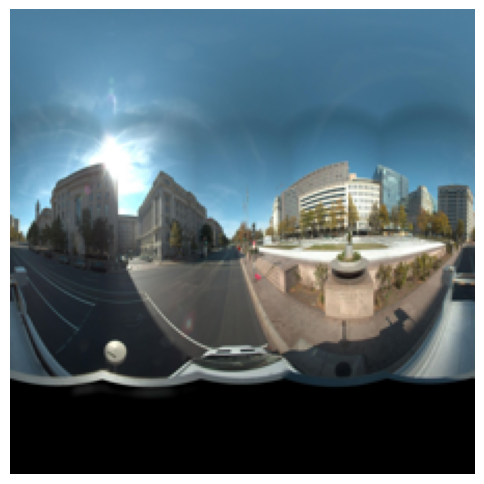

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# Base Vision Transformer Docs: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# VIT_B_16 Docs: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_l_16.html
weights = ViT_L_32_Weights.IMAGENET1K_V1
transform = weights.transforms()

model = vit_l_32(weights=weights)

in_features = model.heads.head.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")

#model = model.to(device=device)
#print(f"Using device: {device}")

Previous head: Linear(in_features=1024, out_features=1000, bias=True)
Previous head: Linear(in_features=1024, out_features=144, bias=True)
Number of classes: 144


In [6]:
model = model.to(device=device)
model = torch.compile(model)
print(f"Using device: {device}")

Using device: cuda


In [7]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)
train_loss_list = []
avg_train_loss_list = []
train_loss = 0
for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        # Move to GPU with non_blocking for better performance
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step() # Moved inside the batch loop for OneCycleLR

        current_loss += loss.item()

    avg_train_loss = current_loss / len(train_dataloader)
    train_loss += avg_train_loss
    print(f"Loss: {avg_train_loss:.3f} ({train_loss / (epoch+1):.3f})")
    train_loss_list.append(avg_train_loss)
    avg_train_loss_list.append(train_loss / (epoch+1))
    # Print current LR to verify schedule
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    torch.save(model.state_dict(), f'vit_b_16_base_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 3.750 (3.750)
LR: 0.000052
EPOCH: 2


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 2.165 (2.957)
LR: 0.000100
EPOCH: 3


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.662 (2.526)
LR: 0.000099
EPOCH: 4


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.369 (2.236)
LR: 0.000097
EPOCH: 5


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.187 (2.026)
LR: 0.000093
EPOCH: 6


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 1.066 (1.866)
LR: 0.000088
EPOCH: 7


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.992 (1.741)
LR: 0.000082
EPOCH: 8


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.944 (1.642)
LR: 0.000075
EPOCH: 9


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.915 (1.561)
LR: 0.000067
EPOCH: 10


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.889 (1.494)
LR: 0.000059
EPOCH: 11


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.869 (1.437)
LR: 0.000050
EPOCH: 12


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.854 (1.388)
LR: 0.000041
EPOCH: 13


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.842 (1.346)
LR: 0.000033
EPOCH: 14


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.833 (1.310)
LR: 0.000025
EPOCH: 15


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.826 (1.277)
LR: 0.000018
EPOCH: 16


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.822 (1.249)
LR: 0.000012
EPOCH: 17


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.820 (1.224)
LR: 0.000007
EPOCH: 18


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.818 (1.201)
LR: 0.000003
EPOCH: 19


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.818 (1.181)
LR: 0.000001
EPOCH: 20


  0%|          | 0/2384 [00:00<?, ?it/s]

Loss: 0.818 (1.163)
LR: 0.000000


In [8]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 1.643
Test Accuracy: 80.97%


In [19]:
from pathlib import Path

cwd = os.getcwd()
directory = Path(cwd)

pth_files = list(directory.glob("*.pth"))
print(len(pth_files))

20


In [23]:
print(train_loss_list)
print(avg_train_loss_list)

[3.7500941470365396, 2.164695613286239, 1.661808973840819, 1.3692523693578356, 1.1866275911663202, 1.0659092539458868, 0.9916710644310353, 0.9439424148591973, 0.914605894869806, 0.8888954723491365, 0.8688889179853785, 0.8537041788433222, 0.8415983204273569, 0.8325919555187625, 0.8262355227598408, 0.8221086899206143, 0.8198066487808355, 0.8183408318549995, 0.8177457843850923, 0.8175793108124061]
[3.7500941470365396, 2.9573948801613894, 2.525532911387866, 2.2364627758803586, 2.026495738937551, 1.8663979914389401, 1.7414370018663823, 1.6417501784904842, 1.5609563691992978, 1.4937502795142816, 1.4369447011934722, 1.3883413243309597, 1.3462841701845287, 1.309591869136974, 1.2773681127118317, 1.2489143987873808, 1.2236727664340545, 1.201154325624107, 1.1809749287167906, 1.1628051478215713]


In [30]:
weights = ViT_L_32_Weights.IMAGENET1K_V1
transform = weights.transforms()
model = vit_l_32(weights=weights)

print(f"Previous head: {model.heads.head}")
model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)
model.num_classes = num_classes
print(f"Previous head: {model.heads.head}")
print(f"Number of classes: {model.num_classes}")


for pth_file in pth_files:

    print(pth_file.name)

    #weights = torch.load(str(pth_file))
    #transform = weights.transforms()

    #model = torch.load(str(pth_file))


    model.load_state_dict(torch.load(str(pth_file), map_location=device), strict=False)
    model = model.to(device=device)
    #model.load_state_dict(weights)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            inputs = transform(inputs)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {avg_test_loss:.3f}")
    print(f"Test Accuracy: {accuracy:.2f}%")

    #break

Previous head: Linear(in_features=1024, out_features=1000, bias=True)
Previous head: Linear(in_features=1024, out_features=144, bias=True)
Number of classes: 144
vit_b_16_base_epoch0.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch1.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch10.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch11.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch12.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch13.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch14.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch15.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch16.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch17.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch18.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch19.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch2.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch3.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch4.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch5.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch6.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch7.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch8.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
vit_b_16_base_epoch9.pth


  0%|          | 0/596 [00:00<?, ?it/s]

Test Loss: 5.030
Test Accuracy: 0.66%
